# NLP feature extraction
From the keywords for each extracted topic using our NLP approach we defined the following three topics:

Topic 1: **Fail.Obey.Signals**

Topic 2: **Speeding**

Topic 3: **Obey.Police.Doc.Light**

The first topic seems to concern traffic violations in which the driver fails to obey traffic signals such as stop signs, red lights, and lane/line markings. We interpret the second topic as the driver driving at an inappropriate speed (mostly too fast). The third topic we interpret as the failure of the driver to obey the police officer, there being issues with the vehicle documentation including the driver's license or license plate, or an issue with the vehicle lights which may lead to a low visibility of the vehicle.

In [1]:
from pathlib import Path
from typing import List

import gensim
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pyLDAvis.gensim
import seaborn as sns
import spacy
import string

from gensim import corpora
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from scipy.io.arff import loadarff

from src.data_preprocessing.data_preprocessor import (
    load_data,
    change_to_numeric,
    feature_engineering,
    transform_label,
    convert_float_to_int,
    drop_cols,
    filter_na,
)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mariastoelben/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
FULL_DATA_PATH = Path("../../data/dataset.csv")
DATA_PATH = Path("../../data/file65ef3a759daf.arff")

## Functions

In [3]:
def preprocessor(data_path: Path, cols: List[str]) -> pd.DataFrame:
    """Load data and perform preprocessing steps.

    Parameters
    -------
    path_ : Path
            Path of the data.
    cols : List
            List of columns to drop.

    Returns
    -------
    data : pd.DataFrame
            Processed data.
    """
    # load the data
    data, _ = load_data(data_path)

    # convert yes/no to 0/1 and year to int
    data = change_to_numeric(data)
    data = convert_float_to_int(data)

    # perform feature engineering on state columns
    data = feature_engineering(data)

    # drop unwished cols
    data = drop_cols(data, cols)

    # transform label to 0/1 for citation
    data = transform_label(data)

    # filter na
    data = filter_na(data)

    return data

In [4]:
def preprocess_text(df: pd.DataFrame, column_name: str = "Description") -> pd.DataFrame:
    """reformats text so that LDA can be applied in the next step

    Parameters
    -------
    df : pd.DataFrame
            Data to transform.
    column_name : (str, optional)
            Name of column to be transformed.
            Defaults to "Description".

    Returns
    -------
    df : pd.DataFrame
            Transformed data.
    """
    # making text lower case
    lowercase_text = df[column_name].apply(lambda x: x.lower())

    # tokenize text
    tokenized_text = lowercase_text.apply(lambda x: nltk.word_tokenize(x))

    # removing stopwords
    stop_words = set(stopwords.words("english"))
    clean_text = tokenized_text.apply(
        lambda tokens: [
            word for word in tokens if word not in stop_words and word not in string.punctuation
        ]
    )

    # lemmatize words
    lemmatized_text = clean_text.apply(
        lambda tokens: [token.lemma_ for token in nlp(" ".join(tokens))]
    )

    df["description_clean"] = lemmatized_text.apply(lambda lem_tokens: " ".join(lem_tokens))

    return df

In [5]:
def create_n_topics(
    df: pd.DataFrame,
    column_name: str = "description_clean",
    n_topics: int = 10,
    random_state: int = 42,
) -> pd.DataFrame:
    """Applies LDA to a text column of DF and adds LDA topic distributions as new features.

    Parameters
    ----------
    df : pd.DataFrame
        Data to transform.
    column_name : str, optional
        Name of the column to be transformed. Defaults to "description_clean".
    num_topics : int, optional
        Number of topics for LDA. Defaults to 10.
    random_stat : int
            Random state of split for reproducibility.

    Returns
    -------
    df : pd.DataFrame
        Transformed data with added LDA topic features.
    """

    # Preprocess text
    df = preprocess_text(df, column_name)

    # Tokenized text is already available from preprocessing but needs to be list of list
    tokenized_text = df[column_name].apply(lambda x: x.split())

    # Create a Gensim dictionary and corpus
    dictionary = corpora.Dictionary(tokenized_text)
    corpus = [dictionary.doc2bow(text) for text in tokenized_text]

    # Train an LDA model
    lda_model = gensim.models.LdaModel(
        corpus=corpus, id2word=dictionary, num_topics=n_topics, passes=10, random_state=random_state
    )

    # Extract LDA topics
    topics = lda_model[corpus]

    for topic in lda_model[corpus]:
        print(topic)

    print(f"Number of topics extracted: {len(topics)}")

    # Add LDA topic distributions as new features
    for i in range(n_topics):
        df[f"Topic_{i+1}"] = [topic[i][1] if i < len(topic) else 0 for topic in topics]

    return df, lda_model, corpus, dictionary

In [6]:
def threshold_transform(data_frame: pd.DataFrame, t: float, columns: list[str]) -> pd.DataFrame:
    """
    Transform specified columns in a DataFrame based on a threshold 't'.

    Parameters
    -------
        data_frame : pd.DataFrame
            The DataFrame to be transformed.
        t : float
            The threshold value.
        columns_to_transform : list
            List of column names to be transformed.

    Returns
    -------
        pandas.DataFrame: A new DataFrame with specified columns transformed.
    """
    transformed_df = data_frame.copy()

    for column in columns:
        transformed_df[column] = (transformed_df[column] >= t).astype(int)

    return transformed_df

## Preprocessed dataset

In [7]:
data, meta = loadarff(DATA_PATH)
data = pd.DataFrame(data)

In [8]:
print("Dimensions of the dataset:", data.shape)

Dimensions of the dataset: (70340, 21)


In [9]:
# remove b string from data
str_df = data.select_dtypes([object])
str_df = str_df.stack().str.decode("utf-8").unstack()
data = pd.concat([str_df, data.select_dtypes(exclude=[object])], axis=1)

In [10]:
# apply preprocessing to data
data = preprocessor(
    DATA_PATH, ["Model", "Charge", "Driver.City", "Arrest.Type", "Commercial.Vehicle"]
)

In [11]:
# load stopwords and en_core_web_sm used in preprocess_text
nltk.download("stopwords")
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mariastoelben/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
data = preprocess_text(data)

In [13]:
tokenized_text = data["description_clean"].apply(lambda x: x.split())
dictionary = corpora.Dictionary(tokenized_text)
corpus = [dictionary.doc2bow(text) for text in tokenized_text]

topic_range = range(2, 21)

models = []
coherence_scores = []

for n_topics in topic_range:
    lda_model = gensim.models.LdaModel(
        corpus=corpus, id2word=dictionary, num_topics=n_topics, passes=10
    )
    models.append(lda_model)
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=data["description_clean"].str.split(),
        dictionary=dictionary,
        coherence="c_v",
    )
    coherence_scores.append(coherence_model.get_coherence())

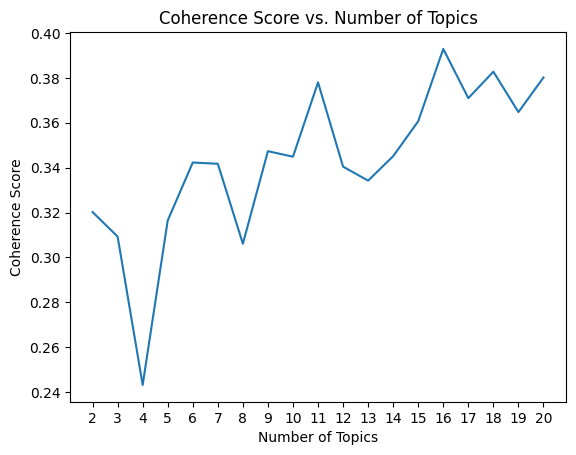

In [14]:
# Plot the coherence scores
plt.plot(topic_range, coherence_scores)
plt.xticks(np.arange(2, 21, step=1))
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.show()

In [15]:
data, lda_model, corpus, dictionary = create_n_topics(
    data, column_name="description_clean", n_topics=3
)

[(0, 0.9047611), (1, 0.047619414), (2, 0.047619484)]
[(0, 0.037037387), (1, 0.9253644), (2, 0.03759821)]
[(0, 0.056160476), (1, 0.05580921), (2, 0.88803035)]
[(0, 0.028768264), (1, 0.7502896), (2, 0.22094215)]
[(0, 0.9047611), (1, 0.047619417), (2, 0.047619488)]
[(0, 0.04392143), (1, 0.63864535), (2, 0.3174332)]
[(0, 0.033340357), (1, 0.033340268), (2, 0.9333194)]
[(0, 0.9253896), (1, 0.037573162), (2, 0.037037216)]
[(0, 0.03341935), (1, 0.93062776), (2, 0.03595295)]
[(0, 0.031492453), (1, 0.93332607), (2, 0.035181496)]
[(0, 0.66661745), (1, 0.2667089), (2, 0.066673644)]
[(0, 0.031767514), (1, 0.8465627), (2, 0.12166984)]
[(0, 0.034090172), (1, 0.9325764), (2, 0.033333454)]
[(0, 0.031492405), (1, 0.93332094), (2, 0.035186686)]
[(0, 0.8333263), (1, 0.083336614), (2, 0.08333712)]
[(0, 0.028768098), (1, 0.75022554), (2, 0.22100635)]
[(0, 0.031767827), (1, 0.84663165), (2, 0.121600494)]
[(0, 0.027779778), (1, 0.027779752), (2, 0.9444405)]
[(0, 0.03741922), (1, 0.03766328), (2, 0.92491746)]

In [16]:
print(data.head())

   Belts   Color  Commercial.License  Contributed.To.Accident  \
0      0    GRAY                   0                        0   
1      0  SILVER                   0                        0   
2      0   BLACK                   0                        0   
3      0   BLACK                   0                        0   
4      0   BLACK                   1                        0   

                                         Description Gender     Make  \
0  DISPLAYING EXPIRED REGISTRATION PLATE ISSUED B...      F  HYUNDAI   
1  DRIVER FAIL TO STOP AT RED TRAFFIC SIGNAL BEFO...      M     FORD   
2      DRIVING UNDER THE INFLUENCE OF ALCOHOL PER SE      M   TOYOTA   
3  PERSON DRIVING MOTOR VEHICLE ON HIGHWAY OR PUB...      M     HOND   
4  DISPLAYING EXPIRED REGISTRATION PLATE ISSUED B...      M     FORD   

   Personal.Injury  Property.Damage   Race      VehicleType  Year  State_MD  \
0                0                0  WHITE  02 - Automobile  2013         0   
1                0

In [17]:
for i in range(3):
    print(i)

0
1
2


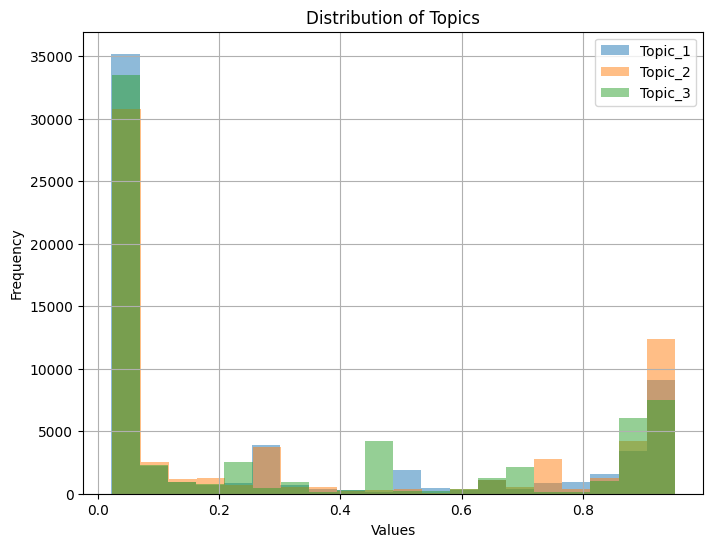

In [18]:
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.hist(data[f"Topic_{i+1}"], alpha=0.5, label=f"Topic_{i+1}", bins=20)

plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title("Distribution of Topics")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# visualing the topic seperation using pyLDAvis
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

In [20]:
data = threshold_transform(data, t=0.334, columns=["Topic_1", "Topic_2", "Topic_3"])

In [21]:
data.head()

Belts   Color  Commercial.License  Contributed.To.Accident  \
0      0    GRAY                   0                        0   
1      0  SILVER                   0                        0   
2      0   BLACK                   0                        0   
3      0   BLACK                   0                        0   
4      0   BLACK                   1                        0   

                                         Description Gender     Make  \
0  DISPLAYING EXPIRED REGISTRATION PLATE ISSUED B...      F  HYUNDAI   
1  DRIVER FAIL TO STOP AT RED TRAFFIC SIGNAL BEFO...      M     FORD   
2      DRIVING UNDER THE INFLUENCE OF ALCOHOL PER SE      M   TOYOTA   
3  PERSON DRIVING MOTOR VEHICLE ON HIGHWAY OR PUB...      M     HOND   
4  DISPLAYING EXPIRED REGISTRATION PLATE ISSUED B...      M     FORD   

   Personal.Injury  Property.Damage   Race      VehicleType  Year  State_MD  \
0                0                0  WHITE  02 - Automobile  2013         0   
1                0                0  OTHER  02 - Automobile  2015         1   
2                0                0  BLACK  02 - Automobile  2000         1   
3                0                0  BLACK  02 - Automobile  2012         1   
4                0                0  WHITE  02 - Automobile  2010         1   

   Driver_State_MD  DL_State_MD  Citation  \
0                0            0         1   
1                1            1         1   
2                1            1         1   
3                1            1         1   
4                1            1         1   

                                   description_clean  Topic_1  Topic_2  \
0      display expire registration plate issue state        1        0   
1     driver fail stop red traffic signal right turn        0        1   
2                     drive influence alcohol per se        0        0   
3  person drive motor vehicle highway public use ...        0        1   
4      display expire registration plate issue state        1        0   

   Topic_3  
0        0  
1        0  
2        1  
3        0  
4        0

Text(0.5, 1.0, 'Correlation plot of numerical features')

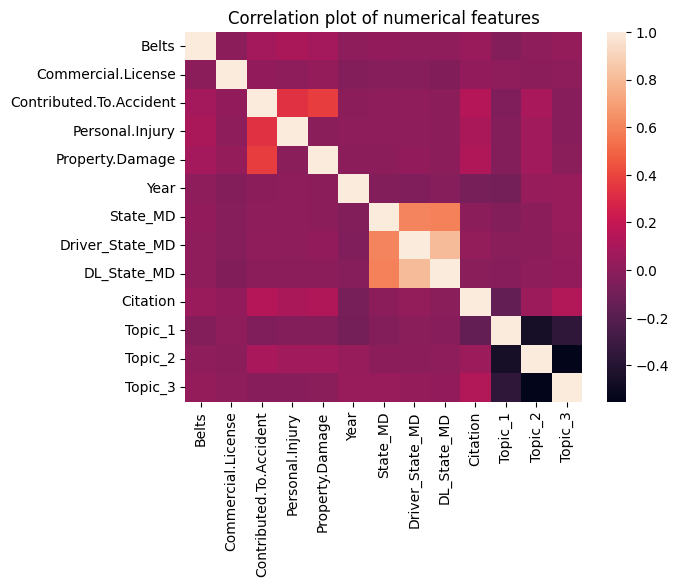

In [22]:
df_numeric = data.select_dtypes(exclude=[object])
# shows correlation of numeric features
corr = df_numeric.corr()
corr

# create heat map of correlation plot
sns.heatmap(corr)
plt.title("Correlation plot of numerical features")